# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq
!pip install timm -q

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 512 kB 34.4 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

In [2]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-07-14 09:49:47 URL:https://uc6d4374ab65d37ef2ef7947c468.dl.dropboxusercontent.com/cd/0/inline2/BpCPTBGPdx2VVJVQHmDAiZB16kc5qEFQtASv2rZe5lZvaNue4IXWB9rD5CPI79_jiXjb-HOkQtvHU21zAE9LHA9KL3wbve1VqjXNm5jbOlMPXY5Gaf2sVJLqyDAH0SGUjiQdLmBkDQOc84mkS0d8x8uIQIwu2Q2qy4yblFqmi5ND14I6PPGJtVCtSLyBzuh4rnmPiPbuEl9KSG_xKRELFp54FhNeFzu6HMYdG8EKgSKEx_hddRMJzHfhPsE3FFsaw-W1h0EkDjv43ePGlCof4JdZo-5AejUX4SFMZFSh2ev16UsiroNM8X2bOuA3gS6tXCzN8qPynzCLoto2TnoJKt1OkiCilj6jsAEeHBEuzxo7WzvONrx6LDcdLxnv7PTQQ3mBcs8fixohb1r7VgQSvlQeWvN90tdXPPGebSrnQr-0yw/file [138777773/138777773] -> "train.zip" [1]
2022-07-14 09:49:52 URL:https://ucdb637b3a9affe07c058636476a.dl.dropboxusercontent.com/cd/0/inline2/BpCaqObSmI3Z_uYbbpTj0hPt_qpUBoTplFdWmiu84WxZZcmE5wgox79gg7U8SpNGyHRKTbHsCDFc-znC-ZfW89E5TddIuUCQ8PSoFIXViqfNsvyUihg97HF6peHCM2GNA3cJmDaUiTW__QzIYEdFSny2bYuBI16L1DOBz4D5mI-1HH3QO0vXNwAmuLiWr2VICzWy1a2U9h-SKedUMpr0axcC4bzzOH9FbyebYOnoI1AA2o3K0b2IF2wshesEQ-bdViAOMYgPturudFk5Q1vfQKos0gdw_RXO5I-IkYnaeUM6Mrp8gQmH8U-4Uo4IJwTTJqP

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [7]:
path = Path('dataset/')

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [10]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [11]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [12]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [13]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [14]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [15]:
len(Path('dataset/test/enfermedad').ls()) #401

506

In [16]:
len(Path('dataset/val/normal').ls()) #401

134

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [17]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [18]:
dls = db.dataloaders(path,bs=128)

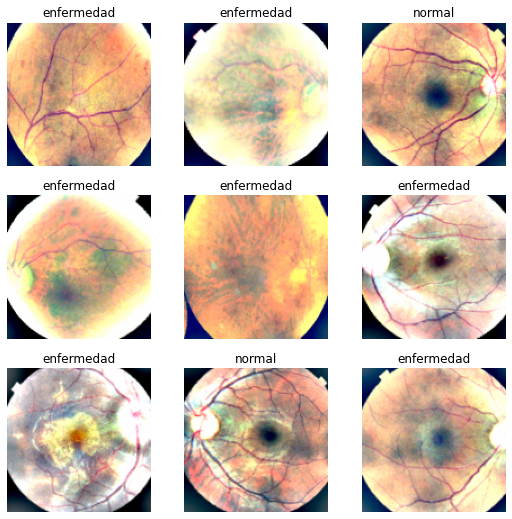

In [19]:
dls.show_batch()

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [ ]:
metrics=[ accuracy, Precision(), Recall(), F1Score() ]
learn = cnn_learner(dls,resnet18, metrics=metrics, cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:275: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.010000000149011612, steep=0.013182567432522774, valley=0.0008317637839354575, slide=0.0063095735386013985)

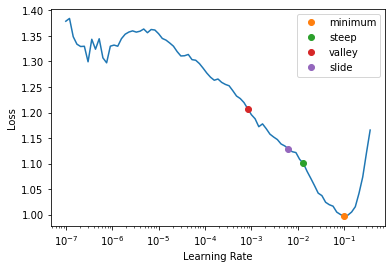

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.102521,0.894504,0.678125,0.388889,0.940299,0.550218,00:08


Better model found at epoch 0 with valid_loss value: 0.8945044279098511.


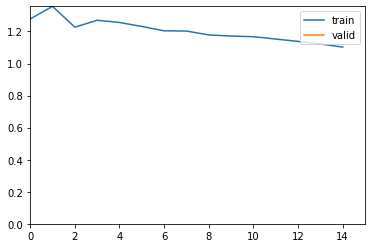

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.912377,0.936199,0.615625,0.349462,0.970149,0.513834,00:08
1,0.883938,0.914860,0.604688,0.341333,0.955224,0.502947,00:08
2,0.857949,0.891513,0.662500,0.378698,0.955224,0.542373,00:08
3,0.824106,0.863870,0.687500,0.396875,0.947761,0.559471,00:08
4,0.786192,0.770590,0.725000,0.426056,0.902985,0.578947,00:09
5,0.754254,0.687036,0.771875,0.475806,0.880597,0.617801,00:08
6,0.717057,0.611078,0.800000,0.513393,0.858209,0.642458,00:08
7,0.672096,0.624155,0.798437,0.511211,0.850746,0.638655,00:08
8,0.638512,0.628955,0.790625,0.500000,0.843284,0.627778,00:08
9,0.604061,0.684629,0.803125,0.518018,0.858209,0.646067,00:09


Better model found at epoch 0 with valid_loss value: 0.9361991882324219.


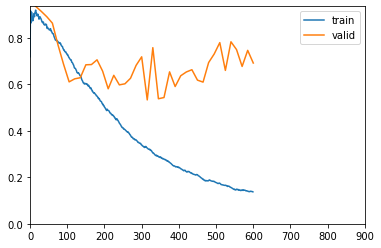

Better model found at epoch 1 with valid_loss value: 0.9148596525192261.
Better model found at epoch 2 with valid_loss value: 0.8915129899978638.
Better model found at epoch 3 with valid_loss value: 0.8638701438903809.
Better model found at epoch 4 with valid_loss value: 0.7705897092819214.
Better model found at epoch 5 with valid_loss value: 0.6870363354682922.
Better model found at epoch 6 with valid_loss value: 0.6110776662826538.
Better model found at epoch 13 with valid_loss value: 0.5813174843788147.
Better model found at epoch 20 with valid_loss value: 0.5334783792495728.
No improvement since epoch 20: early stopping
CPU times: user 1min 23s, sys: 12.5 s, total: 1min 35s
Wall time: 6min 23s


In [ ]:
%%time
learn.fine_tune(60,base_lr=1e-3)

Exportamos el modelo

In [ ]:
learn.to_fp32()
learn.export('Binario_CEL_resnet18.pkl')

## Evaluando el modelo

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.8843749761581421.


(#5) [0.3148506283760071,0.8843749761581421,0.7542372881355932,0.664179104477612,0.7063492063492064]

## Interpretación del modelo

In [ ]:
learn.dls=dls

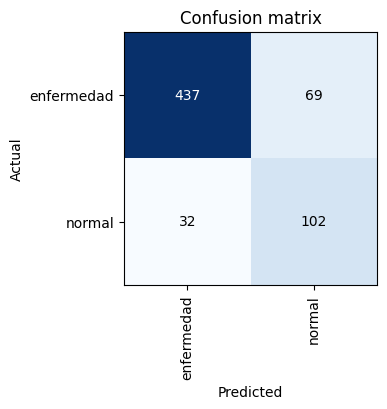

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)

## Resultados

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


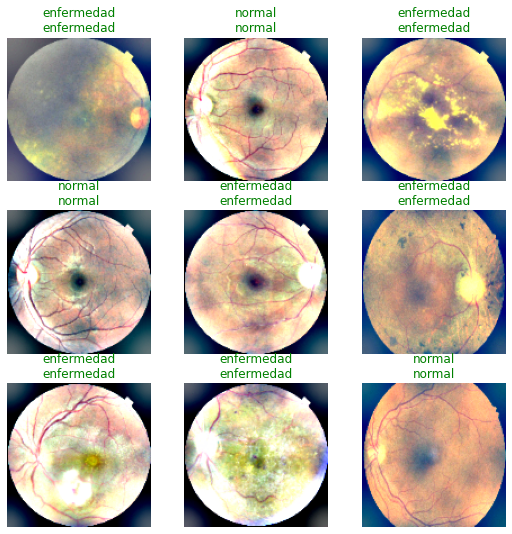

In [23]:
learn_inf = load_learner('Binario_CEL_resnet18_0.88.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
# interp = ClassificationInterpretation.from_learner(learnInterp)
# interp.plot_confusion_matrix(figsize=(4,4),dpi=100)
learnInterp.show_results()